In [23]:
from IPython.display import display

# Run ete3 evol on a list of tree

## Align nucleotide sequences using amino-acids (align codons)

For this exercice we assume you have already aligned the sequences with ete3 build using the following options"
 - use both nucleotide and aminoacids
 - trimal with automated1, we need alignment as clean as possible, CodeML is very sensible to misalignments
 
 This would be the command:
 
```
ete3 build -a fasta/$NAME.faa -n fasta/$NAME.fna --nt-switch-thr 0.0 -w mafft_default-trimal00-none-fasttree_default -o evol/$NAME -t 0.1 -c trimal00.cfg --launch-time 0.1 --nocheck --clearall --noimg -v 0```

with the config file `trimal00.cfg` such as:
```
[trimal00]
                        -automated1 = 
                               _app = trimal
                              _desc = trimal alignment cleaning removing columns with >10% gaps

```

## run simple model codeML

Next we run `ete3 evol` on each of the generated alignments (17 for this tutorial).

We run first a free-branch model, we can do so in parallel using the parallel commmand:

In [ ]:
%%bash

find data/evol -name "*.faa.final_tree.used_alg.fa" | cut -d '/' -f 2 | parallel -j 8 ete3 evol -t data/evol/{}/mafft_default-trimal00-none-fasttree_default/{}.faa.final_tree.nw --alg data/evol/{}/mafft_default-trimal00-none-fasttree_default/{}.faa.final_tree.used_alg.fa --models fb -o data/evol/{}/ --noimg --codeml_binary ~/.etetoolkit/ext_apps-latest/bin/codeml

# Explore results

## check for dS saturation

In [17]:
import os
from ete3 import EvolTree

In [3]:
rpath = 'data/evol/'

In [20]:
good_trees = []
for fam in os.listdir(rpath):
    for model in os.listdir(os.path.join(rpath, fam)):
        if not model.startswith('fb'):
            continue
        tree = EvolTree(os.path.join(rpath, fam, model, 'tree'))
        tree.link_to_evol_model(os.path.join(rpath, fam, model, 'out'), 'fb')
        if all(n.dS < 5 for n in tree.iter_descendants()): # over 5 the dS is considered saturated
            good_trees.append((len(tree), tree, fam)) # we keep length of the tree, tree object, and its nam

In [21]:
len(good_trees)

3

3 trees have trustable levels od dS:

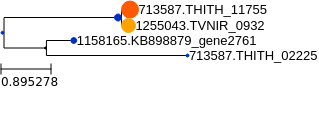

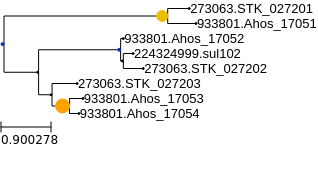

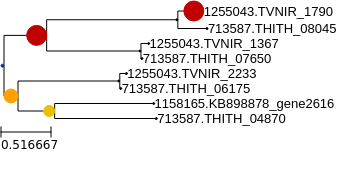

In [25]:
for _, t, _ in good_trees:
    display(t.render('%%inline'))

# Load sequences and tree

# Run free-branch model

# Check for saturation of synonymous sites

In [1]:
! which python

/home/fransua/.miniconda3/envs/etecourse/bin/python
